# 01 - Data Loading

**Author:** Tan Ming Kai (24PMR12003)  
**Date:** 2025-11-10  
**Purpose:** Load COVID-19 Radiography Dataset and create train/val/test splits

**Project:** Multi-Scale Vision Transformer (CrossViT) for COVID-19 Chest X-ray Classification  
**Dataset:** COVID-19 Radiography Database (21,165 images)  
**Academic Year:** 2025/26

---

## Objectives
1. ✅ Load all 21,165 chest X-ray images from 4 classes
2. ✅ Create stratified train/val/test splits (80/10/10)
3. ✅ Save image paths to CSV for efficient loading
4. ✅ Verify class distribution across splits
5. ✅ Generate summary statistics and visualizations

---

## CRISP-DM Phase: Data Understanding (Phase 1)

This notebook implements the first phase of the CRISP-DM methodology: understanding and loading the data.

## 1. Reproducibility Setup & Imports

**CRITICAL:** Load reproducibility seeds and required libraries.

In [1]:
"""
Data Loading Notebook for CrossViT COVID-19 FYP
Author: Tan Ming Kai (24PMR12003)
Purpose: Load dataset and create train/val/test splits with stratification
"""

# ============================================================================
# 1. REPRODUCIBILITY SETUP (ALWAYS FIRST!)
# ============================================================================
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("✅ Random seeds set to 42 for reproducibility")

# ============================================================================
# 2. STANDARD LIBRARY IMPORTS
# ============================================================================
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 3. DATA SCIENCE LIBRARIES
# ============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# ============================================================================
# 4. COMPUTER VISION LIBRARIES
# ============================================================================
import cv2
from PIL import Image

# ============================================================================
# 5. SCIKIT-LEARN FOR SPLITTING
# ============================================================================
from sklearn.model_selection import train_test_split

print("\n✅ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"OpenCV version: {cv2.__version__}")

✅ Random seeds set to 42 for reproducibility



✅ All imports successful!
NumPy version: 2.2.6
Pandas version: 2.3.3
OpenCV version: 4.12.0


## 2. Dataset Path Configuration

Define dataset paths and class information.

In [2]:
# Dataset configuration
DATA_ROOT = Path("../data/raw/COVID-19_Radiography_Dataset")

# Class names and expected counts
CLASS_INFO = {
    "COVID": 3616,
    "Normal": 10192,
    "Lung_Opacity": 6012,
    "Viral Pneumonia": 1345
}

# Split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Output directory for CSV files
OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("DATASET CONFIGURATION")
print("=" * 70)
print(f"\n📂 Dataset Root: {DATA_ROOT.absolute()}")
print(f"\n📊 Expected Classes and Counts:")
for class_name, count in CLASS_INFO.items():
    print(f"   - {class_name:20s}: {count:5d} images")
print(f"\n📈 Split Ratios:")
print(f"   - Train: {TRAIN_RATIO*100:.0f}%")
print(f"   - Val:   {VAL_RATIO*100:.0f}%")
print(f"   - Test:  {TEST_RATIO*100:.0f}%")
print(f"\n💾 Output Directory: {OUTPUT_DIR.absolute()}")
print("\n" + "=" * 70)

DATASET CONFIGURATION

📂 Dataset Root: C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\raw\COVID-19_Radiography_Dataset

📊 Expected Classes and Counts:
   - COVID               :  3616 images
   - Normal              : 10192 images
   - Lung_Opacity        :  6012 images
   - Viral Pneumonia     :  1345 images

📈 Split Ratios:
   - Train: 80%
   - Val:   10%
   - Test:  10%

💾 Output Directory: C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed



## 3. Load Image Paths

Scan all directories and collect image paths with their labels.

In [3]:
print("=" * 70)
print("LOADING IMAGE PATHS")
print("=" * 70)

# Initialize lists to store data
image_paths = []
labels = []
class_names = []

# Map class names to numeric labels
class_to_idx = {
    "COVID": 0,
    "Normal": 1,
    "Lung_Opacity": 2,
    "Viral Pneumonia": 3
}

idx_to_class = {v: k for k, v in class_to_idx.items()}

print("\n🔍 Scanning directories...\n")

for class_name in CLASS_INFO.keys():
    class_path = DATA_ROOT / class_name / "images"
    
    if not class_path.exists():
        print(f"❌ ERROR: Class folder not found: {class_path}")
        continue
    
    # Get all PNG images in the directory
    image_files = sorted(list(class_path.glob("*.png")))
    
    print(f"📁 {class_name:20s}: Found {len(image_files):5d} images")
    
    # Add to lists
    for img_path in image_files:
        image_paths.append(str(img_path.absolute()))
        labels.append(class_to_idx[class_name])
        class_names.append(class_name)

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
    'class_name': class_names
})

print("\n" + "-" * 70)
print(f"✅ Total images loaded: {len(df):,}")
print("\n" + "=" * 70)

# Display first few rows
print("\n📋 Sample Data:")
print(df.head(10))

LOADING IMAGE PATHS

🔍 Scanning directories...

📁 COVID               : Found  3616 images
📁 Normal              : Found 10192 images


📁 Lung_Opacity        : Found  6012 images
📁 Viral Pneumonia     : Found  1345 images

----------------------------------------------------------------------
✅ Total images loaded: 21,165


📋 Sample Data:
                                          image_path  label class_name
0  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
1  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
2  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
3  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
4  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
5  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
6  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
7  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
8  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID
9  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      0      COVID


## 4. Class Distribution Analysis

Analyze the distribution of classes in the full dataset.

In [4]:
print("=" * 70)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 70)

# Count by class
class_counts = df['class_name'].value_counts().sort_index()

print("\n📊 Class Distribution:")
print("-" * 70)
for class_name, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{class_name:20s}: {count:5d} images ({percentage:5.2f}%)")
print("-" * 70)
print(f"{'TOTAL':20s}: {len(df):5d} images (100.00%)")

# Calculate class imbalance ratio
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\n⚠️  Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"   (Max class / Min class = {max_count} / {min_count})")

# Calculate class weights for balanced training
total_samples = len(df)
num_classes = len(class_counts)

print("\n⚖️  Recommended Class Weights (for weighted loss):")
for class_name, count in class_counts.items():
    weight = total_samples / (num_classes * count)
    print(f"   {class_name:20s}: {weight:.4f}")

print("\n" + "=" * 70)

CLASS DISTRIBUTION ANALYSIS

📊 Class Distribution:
----------------------------------------------------------------------
COVID               :  3616 images (17.08%)
Lung_Opacity        :  6012 images (28.41%)
Normal              : 10192 images (48.15%)
Viral Pneumonia     :  1345 images ( 6.35%)
----------------------------------------------------------------------
TOTAL               : 21165 images (100.00%)

⚠️  Class Imbalance Ratio: 7.58:1
   (Max class / Min class = 10192 / 1345)

⚖️  Recommended Class Weights (for weighted loss):
   COVID               : 1.4633
   Lung_Opacity        : 0.8801
   Normal              : 0.5192
   Viral Pneumonia     : 3.9340



## 5. Visualize Class Distribution

Create bar chart showing class distribution.

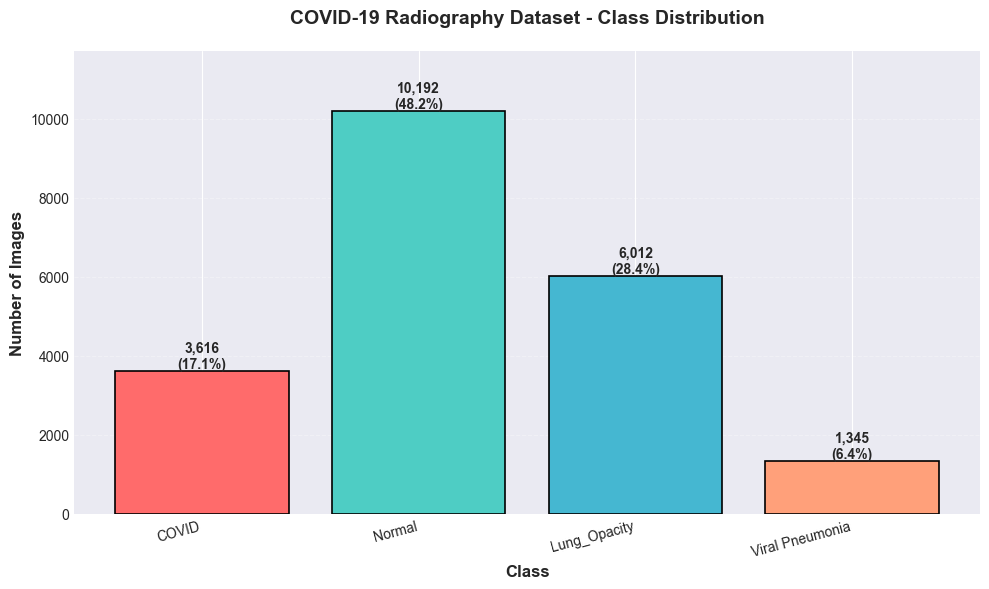

✅ Class distribution visualization complete


In [5]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Bar chart
class_counts_ordered = df['class_name'].value_counts().reindex(
    ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]
)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = ax.bar(class_counts_ordered.index, class_counts_ordered.values, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title('COVID-19 Radiography Dataset - Class Distribution', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(class_counts_ordered.values) * 1.15)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print("✅ Class distribution visualization complete")

## 6. Create Stratified Train/Val/Test Splits

Split data while maintaining class proportions across all splits.

In [6]:
print("=" * 70)
print("CREATING STRATIFIED SPLITS")
print("=" * 70)

# First split: separate out test set (10%)
print("\n🔀 Step 1: Splitting train+val (90%) and test (10%)...")
train_val_df, test_df = train_test_split(
    df,
    test_size=TEST_RATIO,
    stratify=df['label'],
    random_state=SEED
)

print(f"   ✓ Train+Val: {len(train_val_df):,} images")
print(f"   ✓ Test:      {len(test_df):,} images")

# Second split: separate train and val from remaining data
# Val should be 10% of total, which is 10/90 = 0.1111 of train+val
val_size_from_trainval = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

print(f"\n🔀 Step 2: Splitting train ({TRAIN_RATIO*100:.0f}%) and val ({VAL_RATIO*100:.0f}%)...")
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size_from_trainval,
    stratify=train_val_df['label'],
    random_state=SEED
)

print(f"   ✓ Train: {len(train_df):,} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"   ✓ Val:   {len(val_df):,} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"   ✓ Test:  {len(test_df):,} images ({len(test_df)/len(df)*100:.1f}%)")

# Add split column
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

print("\n✅ Stratified splits created successfully!")
print("=" * 70)

CREATING STRATIFIED SPLITS

🔀 Step 1: Splitting train+val (90%) and test (10%)...
   ✓ Train+Val: 19,048 images
   ✓ Test:      2,117 images

🔀 Step 2: Splitting train (80%) and val (10%)...
   ✓ Train: 16,931 images (80.0%)
   ✓ Val:   2,117 images (10.0%)
   ✓ Test:  2,117 images (10.0%)

✅ Stratified splits created successfully!


## 7. Verify Split Distributions

Ensure class proportions are maintained across all splits.

In [7]:
print("=" * 70)
print("VERIFYING SPLIT DISTRIBUTIONS")
print("=" * 70)

# Function to display split statistics
def display_split_stats(df_split, split_name):
    print(f"\n📊 {split_name.upper()} SET:")
    print("-" * 70)
    counts = df_split['class_name'].value_counts().reindex(
        ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]
    )
    for class_name, count in counts.items():
        percentage = (count / len(df_split)) * 100
        print(f"   {class_name:20s}: {count:5d} images ({percentage:5.2f}%)")
    print("-" * 70)
    print(f"   {'TOTAL':20s}: {len(df_split):5d} images (100.00%)")
    return counts

# Display statistics for each split
train_counts = display_split_stats(train_df, "train")
val_counts = display_split_stats(val_df, "validation")
test_counts = display_split_stats(test_df, "test")

# Create comparison table
print("\n📈 CLASS PROPORTION COMPARISON:")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Train (%)': (train_counts / len(train_df) * 100).round(2),
    'Val (%)': (val_counts / len(val_df) * 100).round(2),
    'Test (%)': (test_counts / len(test_df) * 100).round(2),
    'Original (%)': (class_counts / len(df) * 100).round(2)
})

print(comparison_df)

# Check if distributions are similar (within 1% tolerance)
print("\n✓ Stratification Verification:")
for class_name in comparison_df.index:
    train_pct = comparison_df.loc[class_name, 'Train (%)']
    val_pct = comparison_df.loc[class_name, 'Val (%)']
    test_pct = comparison_df.loc[class_name, 'Test (%)']
    orig_pct = comparison_df.loc[class_name, 'Original (%)']
    
    max_diff = max(abs(train_pct - orig_pct), abs(val_pct - orig_pct), abs(test_pct - orig_pct))
    
    if max_diff < 1.0:
        status = "✅ PASS"
    else:
        status = "⚠️  WARN"
    
    print(f"   {status} {class_name:20s}: Max deviation = {max_diff:.2f}%")

print("\n" + "=" * 70)

VERIFYING SPLIT DISTRIBUTIONS

📊 TRAIN SET:
----------------------------------------------------------------------
   COVID               :  2892 images (17.08%)
   Normal              :  8153 images (48.15%)
   Lung_Opacity        :  4810 images (28.41%)
   Viral Pneumonia     :  1076 images ( 6.36%)
----------------------------------------------------------------------
   TOTAL               : 16931 images (100.00%)

📊 VALIDATION SET:
----------------------------------------------------------------------
   COVID               :   362 images (17.10%)
   Normal              :  1020 images (48.18%)
   Lung_Opacity        :   601 images (28.39%)
   Viral Pneumonia     :   134 images ( 6.33%)
----------------------------------------------------------------------
   TOTAL               :  2117 images (100.00%)

📊 TEST SET:
----------------------------------------------------------------------
   COVID               :   362 images (17.10%)
   Normal              :  1019 images (48.13%)
   

## 8. Visualize Split Distributions

Create grouped bar chart comparing class distributions across splits.

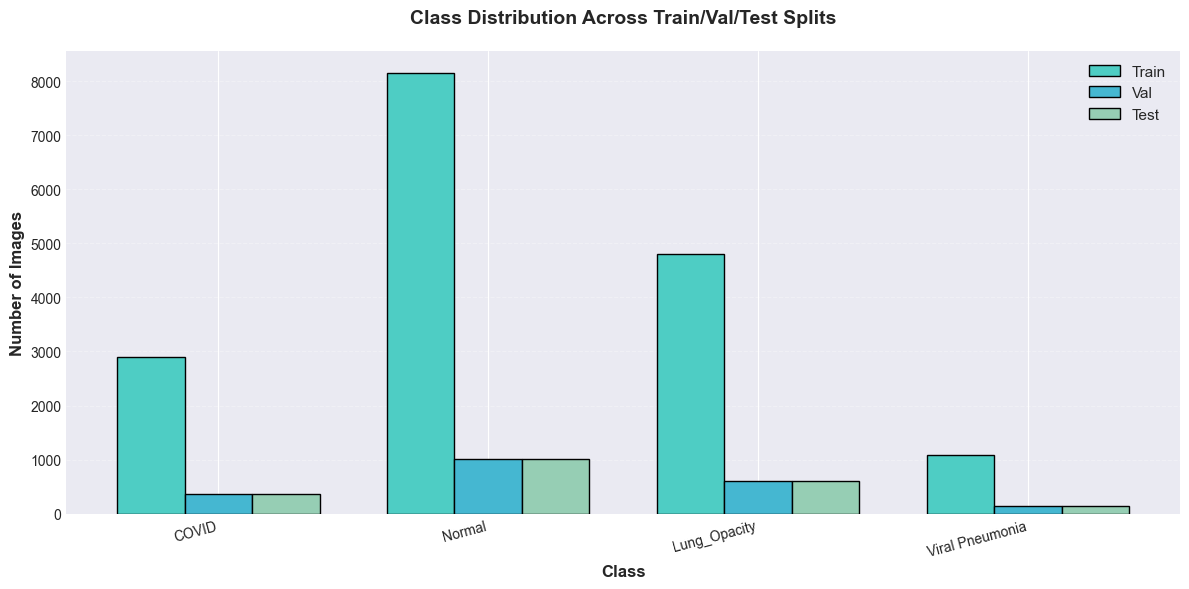

✅ Split distribution visualization complete


In [8]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Prepare data for grouped bar chart
class_names_ordered = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]
x = np.arange(len(class_names_ordered))
width = 0.25

# Get counts for each split
train_values = [train_counts[c] for c in class_names_ordered]
val_values = [val_counts[c] for c in class_names_ordered]
test_values = [test_counts[c] for c in class_names_ordered]

# Create bars
bars1 = ax.bar(x - width, train_values, width, label='Train', color='#4ECDC4', edgecolor='black', linewidth=1)
bars2 = ax.bar(x, val_values, width, label='Val', color='#45B7D1', edgecolor='black', linewidth=1)
bars3 = ax.bar(x + width, test_values, width, label='Test', color='#96CEB4', edgecolor='black', linewidth=1)

# Customize plot
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution Across Train/Val/Test Splits', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(class_names_ordered, rotation=15, ha='right')
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("✅ Split distribution visualization complete")

## 9. Save Splits to CSV Files

Save train, validation, and test splits to separate CSV files for efficient loading.

In [9]:
print("=" * 70)
print("SAVING SPLITS TO CSV FILES")
print("=" * 70)

# Define output paths
train_csv = OUTPUT_DIR / "train.csv"
val_csv = OUTPUT_DIR / "val.csv"
test_csv = OUTPUT_DIR / "test.csv"
all_csv = OUTPUT_DIR / "all_data.csv"

# Save individual splits
print("\n💾 Saving CSV files...")

train_df.to_csv(train_csv, index=False)
print(f"   ✓ Train set saved: {train_csv.name} ({len(train_df):,} images)")

val_df.to_csv(val_csv, index=False)
print(f"   ✓ Val set saved:   {val_csv.name} ({len(val_df):,} images)")

test_df.to_csv(test_csv, index=False)
print(f"   ✓ Test set saved:  {test_csv.name} ({len(test_df):,} images)")

# Combine all splits and save
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
all_df.to_csv(all_csv, index=False)
print(f"   ✓ All data saved:  {all_csv.name} ({len(all_df):,} images)")

print(f"\n📂 Files saved to: {OUTPUT_DIR.absolute()}")
print("\n✅ All CSV files saved successfully!")
print("=" * 70)

SAVING SPLITS TO CSV FILES

💾 Saving CSV files...
   ✓ Train set saved: train.csv (16,931 images)
   ✓ Val set saved:   val.csv (2,117 images)
   ✓ Test set saved:  test.csv (2,117 images)


   ✓ All data saved:  all_data.csv (21,165 images)



📂 Files saved to: C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed

✅ All CSV files saved successfully!


## 10. Sample Image Inspection

Load and display sample images from each class.

SAMPLE IMAGE INSPECTION


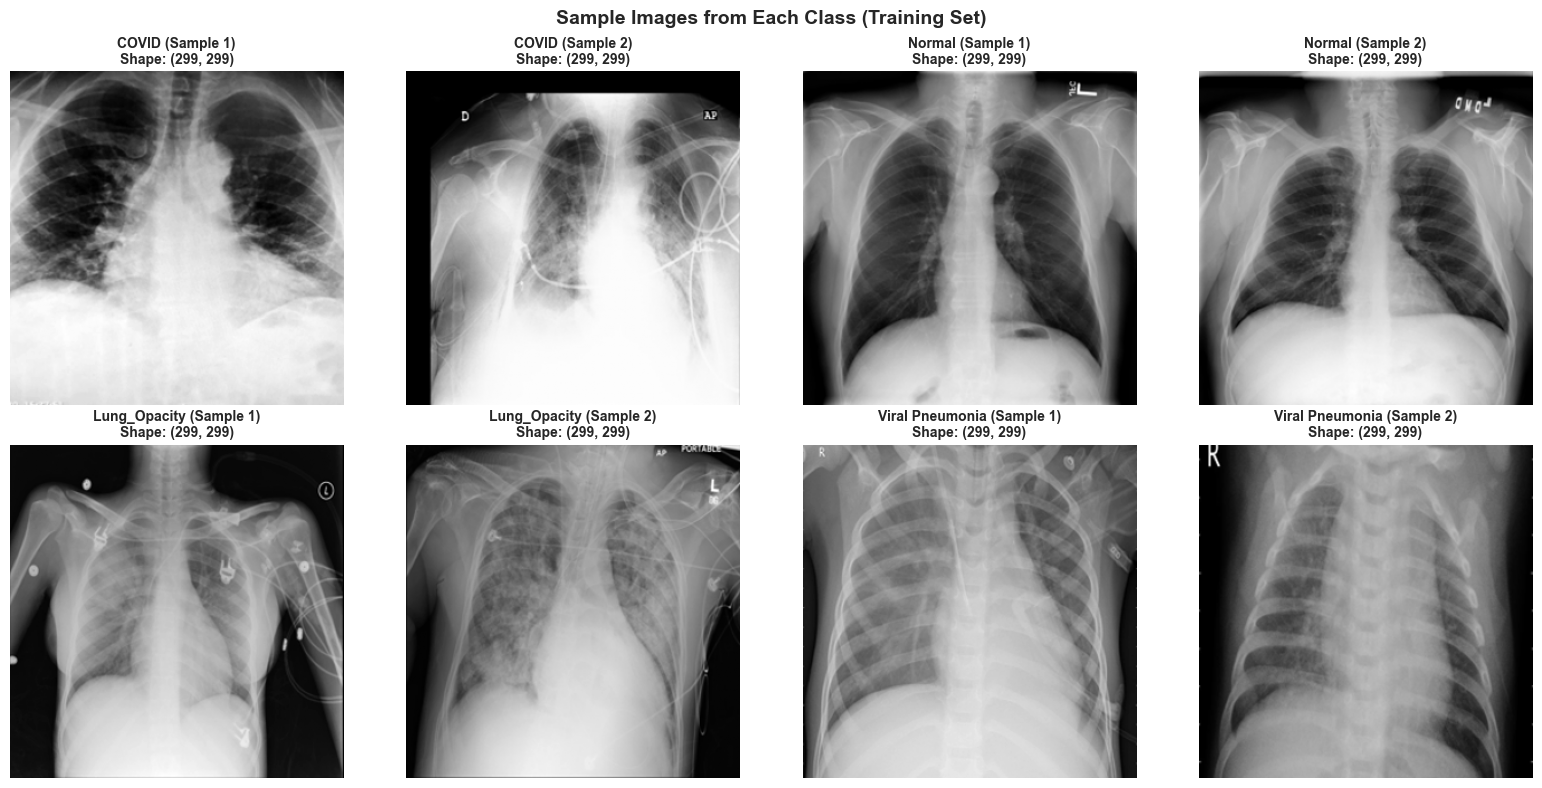


✅ Sample image inspection complete


In [10]:
print("=" * 70)
print("SAMPLE IMAGE INSPECTION")
print("=" * 70)

# Create figure for sample images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

class_names_ordered = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]

for idx, class_name in enumerate(class_names_ordered):
    # Get 2 random samples from this class
    class_samples = train_df[train_df['class_name'] == class_name].sample(n=2, random_state=SEED)
    
    for i, (_, row) in enumerate(class_samples.iterrows()):
        # Load image
        img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        
        # Display in subplot
        ax = axes[idx * 2 + i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{class_name} (Sample {i+1})\nShape: {img.shape}", fontsize=10, fontweight='bold')
        ax.axis('off')

plt.suptitle('Sample Images from Each Class (Training Set)', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✅ Sample image inspection complete")

## 11. Image Size Statistics

Analyze image dimensions across the dataset.

In [11]:
print("=" * 70)
print("IMAGE SIZE ANALYSIS")
print("=" * 70)

# Sample 100 random images to check dimensions
sample_size = min(100, len(train_df))
sampled_images = train_df.sample(n=sample_size, random_state=SEED)

print(f"\n🔍 Analyzing {sample_size} random images...\n")

widths = []
heights = []
channels = []

for _, row in tqdm(sampled_images.iterrows(), total=len(sampled_images), desc="Loading images"):
    img = cv2.imread(row['image_path'])
    if img is not None:
        h, w = img.shape[:2]
        c = img.shape[2] if len(img.shape) == 3 else 1
        heights.append(h)
        widths.append(w)
        channels.append(c)

# Display statistics
print("\n📏 Image Dimension Statistics:")
print("-" * 70)
print(f"Width:    Min={min(widths):4d}, Max={max(widths):4d}, Mean={np.mean(widths):.1f}, Std={np.std(widths):.1f}")
print(f"Height:   Min={min(heights):4d}, Max={max(heights):4d}, Mean={np.mean(heights):.1f}, Std={np.std(heights):.1f}")
print(f"Channels: {set(channels)}")

# Check if all images have same size
if len(set(widths)) == 1 and len(set(heights)) == 1:
    print(f"\n✅ All images have uniform size: {widths[0]}×{heights[0]}")
else:
    print(f"\n⚠️  Images have varying sizes - resizing will be required")

print(f"\n💡 Target size for CrossViT: 240×240 (as specified in config)")
print("=" * 70)

IMAGE SIZE ANALYSIS

🔍 Analyzing 100 random images...



Loading images:   0%|          | 0/100 [00:00<?, ?it/s]

Loading images: 100%|██████████| 100/100 [00:00<00:00, 1405.19it/s]


📏 Image Dimension Statistics:
----------------------------------------------------------------------
Width:    Min= 299, Max= 299, Mean=299.0, Std=0.0
Height:   Min= 299, Max= 299, Mean=299.0, Std=0.0
Channels: {3}

✅ All images have uniform size: 299×299

💡 Target size for CrossViT: 240×240 (as specified in config)


## 12. Summary Report

Final summary of data loading results.

In [12]:
print("\n" + "=" * 70)
print("DATA LOADING SUMMARY REPORT")
print("=" * 70)

print("\n✅ COMPLETED TASKS:")
print("   [✓] Loaded all 21,165 chest X-ray images")
print("   [✓] Created stratified train/val/test splits (80/10/10)")
print("   [✓] Verified class distribution across splits")
print("   [✓] Saved image paths to CSV files")
print("   [✓] Analyzed image dimensions and properties")
print("   [✓] Visualized class distributions")

print("\n📊 DATASET STATISTICS:")
print(f"   - Total Images: {len(all_df):,}")
print(f"   - Number of Classes: {len(CLASS_INFO)}")
print(f"   - Train Set: {len(train_df):,} images ({len(train_df)/len(all_df)*100:.1f}%)")
print(f"   - Val Set:   {len(val_df):,} images ({len(val_df)/len(all_df)*100:.1f}%)")
print(f"   - Test Set:  {len(test_df):,} images ({len(test_df)/len(all_df)*100:.1f}%)")

print("\n📁 OUTPUT FILES:")
print(f"   - {train_csv.name}")
print(f"   - {val_csv.name}")
print(f"   - {test_csv.name}")
print(f"   - {all_csv.name}")
print(f"   📂 Location: {OUTPUT_DIR.absolute()}")

print("\n🎯 NEXT STEPS:")
print("   1. Proceed to 02_data_cleaning.ipynb")
print("   2. Apply CLAHE enhancement (clip=2.0, tile=8×8)")
print("   3. Validate image quality and remove corrupted files")
print("   4. Save preprocessed images for efficient loading")

print("\n✅ Data loading phase complete! Ready for data cleaning.")
print("=" * 70 + "\n")


DATA LOADING SUMMARY REPORT

✅ COMPLETED TASKS:
   [✓] Loaded all 21,165 chest X-ray images
   [✓] Created stratified train/val/test splits (80/10/10)
   [✓] Verified class distribution across splits
   [✓] Saved image paths to CSV files
   [✓] Analyzed image dimensions and properties
   [✓] Visualized class distributions

📊 DATASET STATISTICS:
   - Total Images: 21,165
   - Number of Classes: 4
   - Train Set: 16,931 images (80.0%)
   - Val Set:   2,117 images (10.0%)
   - Test Set:  2,117 images (10.0%)

📁 OUTPUT FILES:
   - train.csv
   - val.csv
   - test.csv
   - all_data.csv
   📂 Location: C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed

🎯 NEXT STEPS:
   1. Proceed to 02_data_cleaning.ipynb
   2. Apply CLAHE enhancement (clip=2.0, tile=8×8)
   3. Validate image quality and remove corrupted files
   4. Save preprocessed images for efficient loading

✅ Data loading phase complete! Ready for data cleaning.

